<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/SI_Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title import modules
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import imageio
from IPython.display import Image
from IPython import display
import time
from typing import Tuple, List
from model import model
from spread_likelihood import calculate_spread_likelihood

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Learning the parameters of a discrete Probabilistic Cellular Automaton

Within this notebook, we consider a Probabilistic Cellular Automata (PCA) model
for the diffusive spread of a news item [(adapting a toy example for Interactive Markov Chains)](https://www.tandfonline.com/doi/abs/10.1080/0022250X.1976.9989852). 

Using the [PCA framework](https://link.springer.com/book/10.1007/978-3-319-65558-1), we define:

- The Graph $G$ to be a 2D lattice of $(K,K)$ regular cells
- The Alphabet $S:= \{0,1\}$
- The neighborhood $V_k$ of cell $k$ is the square Moore neighborhood with distance 1

The probability of reaching a configuration $\sigma \in S^{K\times K}$ from a current configuration $\mu \in S^{K\times K}$ is:

$$P(\sigma | \mu) = \prod_{k \in G} p(\sigma_k|\mu_{V_k})$$

Where we define $p(\sigma_k|\mu_{V_k})$, the probability of cell $k$ transitioning to state $\sigma_k$ given the state of its' neighborhood $\mu_{V_k}$ as:

$$p(\sigma_k|\mu_{V_k}) = \begin{pmatrix}
1 & 1-(1-\beta)^{N_k(n)} \\
0 & (1-\beta)^{N_k(n)}
\end{pmatrix}$$

The probability matrix represents, that once a person is aware of the news, they stay aware ($p_{11} = 1$, $p_{21}=0$). The probability, with which an uninformed person stays uninformed at time $n+1$ depends on the amount of local neighbors that are informed at time $n$, $N_k(n)$. Given a rate of spread $\beta$ (the diffusion coefficient), the probability to stay unaware is $p_{22}= (1-\beta)^{N_k(n)}$. Conversely, the probability that the news spread to cell $k$ is $p_{21} = 1 - p_{22} = 1-(1-\beta)^{N_k(n)}$.

### 1. Defining a function that padds the grid using a periodic Torus

In order to handle the border conditions of the CA, we will define a continuous torus by periodically wrapping around the border of the CA. E.g., for a $(K, K)$-sized CA, the neighbor of cell $(0,3)$ will be cell 
$(K-1,3)$. Equivalently, for cell $(2,0)$, the left neighbor would be $(2,K-1)$.


### 2. Defining a Convolution that finds the number of active neighbors for each cell

The update of cell $k$ depends on the configuration of it's neighborhood $\mu_{V_k}$. More directly, we care about the number of active (state=1) neighbors of
cell $k$. To find the amount, we can simply apply a $3\times3$ convolution onto $k$ with the following kernel:

$$F(\mu_{V_k}) = \begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast \mu_{V_k}$$

### 3. Defining a function to calculate the likelihood of the news item spreading to a cell

We get the likelihood of each cell being activated as:

$$p(\sigma=1|\mu_{V_k})=1-(1-\beta)^{F(\mu_{V_k})}$$

resulting in a $(K,K)$ matrix, where each entry $(i,j)$ corresponds to the probability of the cell at the lattice coordinates $i,j$ being activated.

### 4. Defining a differentiable approximation of the heaviside step-function

$$H(x) \approx \frac{1}{2} + \frac{1}{2}\text{tanh}(kx) = \frac{1}{1+e^{-2kx}}$$



## Defining the PCA class

## Testing the class and helper functions

## Visualizing the Model

## Working out the learning method for single samples

$$
Y= F(x) = \begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x
, x \in S^{K\times K}
$$

$$
G(x, Y, \beta) = \begin{pmatrix}
(1-(1-\beta)^{Y_{11}})(1-x_{11}) & \dots & (1-(1-\beta)^{Y_{k1}})(1-x_{k1}) \\
\dots & \dots & \dots \\
(1-(1-\beta)^{Y_{1k}})(1-x_{1k}) & \dots & (1-(1-\beta)^{Y_{kk}})(1-x_{kk}) 
\end{pmatrix}
$$

**Idea:** We have a tuple $(x_{t}, x_{t+1})$. G tells us how likely each pixel is to transition to an activated state. The likelihood of $x_{t+1}$ is given by the total likelihood of transitions. Example:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
G(x_t) = l = \begin{pmatrix}
0.1 & 0.1 & 0.1 \\
0.1 & 1 & 0.1 \\
0.1 & 0.1 & 0.1 
\end{pmatrix},
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

$$
P(x_{t+1}|x_t) 
= 
\prod \begin{pmatrix}
(1-x_{t+1}^{11})(1-l^{11})+x_{t+1}^{11}l^{11} & 
\dots & 
(1-x_{t+1}^{13})(1-l^{13})+x_{t+1}^{13}l^{13} \\
\dots & 
\dots & 
\dots \\
(1-x_{t+1}^{31})(1-l^{21})+x_{t+1}^{21}l^{21} & 
\dots & 
(1-x_{t+1}^{33})(1-l^{23})+x_{t+1}^{23}l^{23} \\
\end{pmatrix} 
=
\prod \begin{pmatrix}
(1-0.1) & 0.1 & (1-0.1) \\
(1-0.1) & 1 & (1-0.1) \\
(1-0.1) & 0.1 & 0.1 
\end{pmatrix} 
=
\prod \begin{pmatrix}
0.9 & 0.1 & 0.9 \\
0.9 & 1 & 0.9 \\
0.9 & 0.1 & 0.1 
\end{pmatrix} 
\approx 0.0006
$$

This way, we can calculate the likelihood of each transition within the dataset.

**Objective:** Find the parameter $\beta$ that maximizes the likelihood of the sample transition





In [27]:
def P(likelihood, x_t:t.Tensor, x_tt:t.Tensor) -> t.Tensor:
  """
  Returns a likelihood matrix. For each cell, calculates the likelihood of transitioning
  from the state it was in x_t, to the state it is in x_tt.

  x_t (np.ndarray): The previous state of the PCA (time t).
  x_tt (np.ndarray): The current state of the PCA (time t+1).
  beta (float): The diffusion coefficient of the PCA model.
  verbose (boolean, optional): Whether additional information is printed.
  """
  return (1-x_t)*(1-x_tt)*(1-likelihood)+(x_tt*likelihood*(1-x_t)+x_t)

def total_likelihood(p, x_t:np.ndarray, x_tt:np.ndarray) -> float:
  """
  Calculate the total likelihood of transitioning from grid state <x_t> to grid
  state <x_tt>.

  x_t (np.ndarray): The previous state of the grid (time step t).
  x_tt (np.ndarray): The current state of the grid (time step t+1).
  beta (float): The diffusion coefficient of the PCA.
  """
  return t.sum(t.prod(p, dim=0))

tensor([[[0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.]]])
tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 1.]]])


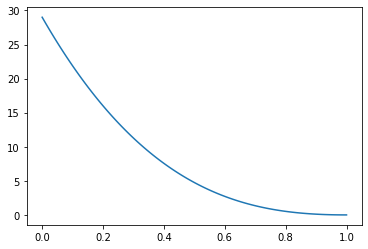

In [33]:
from torch.autograd import Variable
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
print(x_t)
x_tt = t.zeros((1,3,3))
x_tt[0,1,1] = 1.
x_tt[0,2,1] = 1.
x_tt[0,2,2] = 1.
x_tt[0,0,1] = 1.
print(x_tt)


betas = t.linspace(0,1,100)
gradients = []
tot_likelihoods = []
for beta in betas:
    beta.requires_grad_()
    test = calculate_spread_likelihood(x_tt, beta)
    p = P(test, x_t, x_tt)
    tot_likelihood = total_likelihood(p, x_t, x_tt)
    gradient = t.autograd.grad(tot_likelihood, beta)[0]
    gradients.append(gradient.detach().numpy())
    tot_likelihoods.append(tot_likelihood.detach().numpy())

plt.plot(betas, gradients, label="grd w.r.t. p")


In [ ]:
# @title Tests
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
x_tt = t.zeros((1,3,3))
x_tt[0,1,1] = 1.
x_tt[0,2,1] = 1.
x_tt[0,2,2] = 1.
x_tt[0,0,1] = 1.
beta = t.tensor(0.1)

p = P(x_t, x_tt, beta)

print("State x_t")
print(x_t)
print("-------------")
print("State x_t+1")
print(x_tt)
print("-------------")
print("Likelihood matrix P(x_t+1|x_t)")
print(p)
print("-------------")
print("Total Likelihood P(x_t+1|x_t)")
print(total_likelihood(x_t, x_tt, beta))

betas = t.linspace(0,1,100)
betas.requires_grad_()
likelihoods = [total_likelihood(x_t, x_tt, b) for b in betas]
gradients = t.autograd.grad(likelihoods, betas, is_grads_batched=True)
gradients = [grad(total_likelihood, argnums=2)(x_t,x_tt,b) for b in betas]
plt.plot(betas, likelihoods, label="likelihood")
plt.plot(betas, gradients, label="gradient")
plt.xlabel("beta")
plt.legend()

assert "{:0.2f}".format(p[0,0,0]) == "0.90"
assert "{:0.2f}".format(p[0,0,1]) == "0.10"
assert "{:0.2f}".format(p[0,0,2]) == "0.90"
assert "{:0.2f}".format(p[0,1,0]) == "0.90"
assert "{:0.2f}".format(p[0,1,1]) == "1.00"
assert "{:0.2f}".format(p[0,1,2]) == "0.90"
assert "{:0.2f}".format(p[0,2,0]) == "0.90"
assert "{:0.2f}".format(p[0,2,1]) == "0.10"
assert "{:0.2f}".format(p[0,2,2]) == "0.10"

assert "{:0.8f}".format(total_likelihood(x_t,x_tt,beta)) == "{:0.8f}".format(0.9**5 * 0.10000002**3)

x_t = jnp.zeros((2,3,3))
x_t = x_t.at[:,1,1].set(1)

x_tt = jnp.zeros((2,3,3))
x_tt = x_tt.at[:,1,1].set(1)

x_tt = x_tt.at[0,2,1].set(1)
x_tt = x_tt.at[0,2,2].set(1)
x_tt = x_tt.at[0,0,1].set(1)

x_tt = x_tt.at[1,0,0].set(1)
x_tt = x_tt.at[1,2,0].set(1)
x_tt = x_tt.at[1,1,2].set(1)

p = P(x_t, x_tt, 0.1)
assert "{:0.2f}".format(p[0,0,0]) == "0.90"
assert "{:0.2f}".format(p[0,0,1]) == "0.10"
assert "{:0.2f}".format(p[0,0,2]) == "0.90"
assert "{:0.2f}".format(p[0,1,0]) == "0.90"
assert "{:0.2f}".format(p[0,1,1]) == "1.00"
assert "{:0.2f}".format(p[0,1,2]) == "0.90"
assert "{:0.2f}".format(p[0,2,0]) == "0.90"
assert "{:0.2f}".format(p[0,2,1]) == "0.10"
assert "{:0.2f}".format(p[0,2,2]) == "0.10"

assert "{:0.2f}".format(p[1,0,0]) == "0.10"
assert "{:0.2f}".format(p[1,0,1]) == "0.90"
assert "{:0.2f}".format(p[1,0,2]) == "0.90"
assert "{:0.2f}".format(p[1,1,0]) == "0.90"
assert "{:0.2f}".format(p[1,1,1]) == "1.00"
assert "{:0.2f}".format(p[1,1,2]) == "0.10"
assert "{:0.2f}".format(p[1,2,0]) == "0.10"
assert "{:0.2f}".format(p[1,2,1]) == "0.90"
assert "{:0.2f}".format(p[1,2,2]) == "0.90"

assert "{:0.8f}".format(total_likelihood(x_t,x_tt,beta)) == "{:0.8f}".format(0.9**5 * 0.10000002**3 * 2)


**Exercise 1**: If we try to estimate beta for a single transition sample 

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

We can work out the solution analytically. Every cell around the seed has 1 neighbor, reducing the probability for activation to $1-(1-\beta)^1=\beta$. This means, that every cell transitions with probability $\beta$ from inactive to active. In our example, 3 out of 8 cells transition to the active state. This is equivalent to stating that out of 8 independent bernoull trials, 3 were successful. The maximum likelihood estimate for $\beta$ is hence $\frac{3}{8}=0.375$. 

We can show, that the gradient-based method does converge towards this value:

In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,3,3))
x_t = x_t.at[0,1,1].set(1)
x_tt = jnp.zeros((1,3,3))
x_tt = x_tt.at[0,1,1].set(1)
x_tt = x_tt.at[0,2,1].set(1)
x_tt = x_tt.at[0,2,2].set(1)
x_tt = x_tt.at[0,0,1].set(1)

beta = 0.5

for i in range(50):
  #print(f"Gradient {grad(total_likelihood, argnums=2)(x_t,x_tt,beta)}")
  beta = beta + grad(total_likelihood, argnums=2)(x_t,x_tt,beta)
  #print(f"updated beta: {beta}")
print(f"Final Beta: {beta}")

Final Beta: 0.3750137388706207


**Exercise 2:** We consider a more complex example:
$$
x_t = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 1 & 0 \\
1 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

The risk convolution $Y$ here is given as:

$$Y = 
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x
=
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast 
\begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}
= 
\begin{pmatrix}
3 & 2 & 3 \\
3 & 2 & 3 \\
3 & 2 & 3 
\end{pmatrix}
$$

It follows, that the risk matrix is given by:

$$
L = 
\begin{pmatrix}
3 & 2 & 3 \\
3 & 2 & 3 \\
3 & 2 & 3 
\end{pmatrix}
$$

The probability of cells [$x_{11}, x_{21}, x_{31}, x_{13}, x_{23}, x_{33}$] transitioning is thus respectively given by: $1-(1-\beta)^3$

$$
1-(1-\beta)^3
$$
$$
= 1- 1 - 3 \beta + 3 \beta^2 - \beta^3
$$
$$
= -3\beta+3\beta^2-\beta^3
$$

Three out of the six trials are successful, giving us an empirical probability of $0.5$. It follows that:

$$
0.5 = -3\beta+3\beta^2-\beta^3 \approx 0.206299
$$

We can again show, that the gradient-based approach converges to this value for beta:

In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,3,3))
x_t = x_t.at[0,:,1].set(1)
print(x_t)
x_tt = jnp.zeros((1,3,3))
x_tt = x_tt.at[0,:,1].set(1)
x_tt = x_tt.at[0,0,0].set(1)
x_tt = x_tt.at[0,1,0].set(1)
x_tt = x_tt.at[0,2,2].set(1)
print(x_tt)
calculate_spread_likelihood(x_t, 0.1)
p = P(x_t, x_tt, 0.1)
print(p)

def update(x_t, x_tt, beta, lr=0.01):
  return beta + lr * grad(total_likelihood, argnums=2)(x_t,x_tt,beta)

def train(x_t, x_tt, beta, lr=0.01, num_steps=1000, verbose=False):
  for i in range(num_steps):
    beta = update(x_t,x_tt,beta)
    if verbose and i % 10 == 0:
      print(f"beta after step {i}: {beta}")
  return beta

betas = np.linspace(0.01,1,20)
print(betas)
for beta in betas:
  print(f"------------\nstarting with beta: {beta}")
  final_beta = train(x_t, x_tt, beta)
  print(f"beta after 1000 gradient steps: {final_beta}")

**Exercise 3:** We consider another example transition of the form:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

applying a periodic Torus padding to $x_t$ gives us the following $7\times7$ matrix:

$$
\left[\begin{array}{c|ccccc|c} 
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right]
$$

We get a risk matrix L of:

$$
L = 
\begin{pmatrix}
1 & 1 & 0 & 0 & 1 \\
1 & 3 & 2 & 1 & 1 \\
2 & 2 & 1 & 1 & 1\\
1 & 2 & 2 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

We find 11 entries with one active neighbor, respectively. Two of these are active themselves, removing them from consideration. Hence, it remains that we have 9 bernoulli trials with probability $\beta$, of which 2 is successful.

Further, we find 5 entries with two active neighbors, respectively. One of them is active at time $t$, leaving us with 4 bernoulli trials of probability $\beta^2-2\beta$. Out of these, 3 were successful.

Finally, there is one successful trial with 3 active neighbors.

We can write the total likelihood of this event as a bernoulli chain of form:

$$
\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)
$$

We can now use the gradient-based to find the beta, for which this transition is maximally likely, by setting:

$$
\frac{\partial}{\partial \beta}[\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)]=0
$$

We expect our approach to converge towards $\beta \approx 0.35519$


In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,5,5))
x_t = x_t.at[0,2,2].set(1)
x_t = x_t.at[0,2,1].set(1)
x_t = x_t.at[0,1,0].set(1)
print(x_t)
print("-----------------")
x_tt = jnp.zeros((1,5,5))
x_tt = x_tt.at[0,0,0].set(1)
x_tt = x_tt.at[0,1,1].set(1)
x_tt = x_tt.at[0,2,2].set(1)
x_tt = x_tt.at[0,1,2].set(1)
x_tt = x_tt.at[0,2,1].set(1)
x_tt = x_tt.at[0,2,0].set(1)
x_tt = x_tt.at[0,1,2].set(1)
x_tt = x_tt.at[0,1,0].set(1)
x_tt = x_tt.at[0,3,1].set(1)
x_tt = x_tt.at[0,3,3].set(1)
print(x_tt)
print("-------------------")
print(periodic_padding(x_t))
print("-------------------")
print(risk_convolution2D(x_t))
print("-------------------")
print(calculate_spread_likelihood(x_t, 0.1))
print("-------------------")
p = P(x_t, x_tt, 0.1)
print(p)

def update(x_t, x_tt, beta, lr=0.01):
  return beta + lr * grad(total_likelihood, argnums=2)(x_t,x_tt,beta)

def train(x_t, x_tt, beta, lr=0.01, num_steps=1000, verbose=False):
  for i in range(num_steps):
    beta = update(x_t,x_tt,beta, lr)
    if verbose and i % 100 == 0:
      print(f"beta after step {i}: {beta}")
  return beta

beta = 0.2

result = train(x_t, x_tt, beta, num_steps=3_000, lr=0.1, verbose=True)
print(f"beta after optimization: {result}")

[[[0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
-----------------
[[[1. 0. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [0. 1. 0. 1. 0.]
  [0. 0. 0. 0. 0.]]]
-------------------
[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 1.]
  [0. 0. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
-------------------
[[[[1. 1. 0. 0. 1.]
   [1. 3. 2. 1. 1.]
   [2. 2. 1. 1. 1.]
   [1. 2. 2. 1. 0.]
   [0. 0. 0. 0. 0.]]]]
-------------------
[[[0.10000002 0.10000002 0.         0.         0.10000002]
  [0.10000002 0.27100003 0.19000006 0.10000002 0.10000002]
  [0.19000006 0.19000006 0.10000002 0.10000002 0.10000002]
  [0.10000002 0.19000006 0.19000006 0.10000002 0.        ]
  [0.         0.         0.         0.         0.        ]]]
-------------------
[[[0.10000002 0.9        1.         1.         0.9       ]
  [1.         0.27100003 0.19000006 0.9        0.9       ]
  [0.19000006

## Working out the method for a dataset of state transitions, sampled with the same $\beta$

optimize the sum of the log likelihoods of the samples.

In [ ]:
# @title defining hyperparameters

grid_size = 9 #@param {type:"number"}
w=h=grid_size
beta = 0.08 #@param {type:"slider", min:0, max:1, step:0.01}
num_sequences = 100 # @param {type:"number"}
steps_per_sequence = 20
sequences = np.zeros((num_sequences, steps_per_sequence, h, w))

(1900, 2, 9, 9)


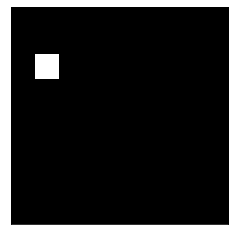

In [ ]:
# @title generate dataset
batch = News_Spread_PCA(w,h,1,num_sequences,beta)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch.grids[:,:,:,-1]
  batch.evolve()
np.save("./sequence_data", sequences)
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
np.save("./dataset", dataset)
print(dataset.shape)

In [ ]:
# @title define helper functions

def neg_log_likelihood(x_t:np.ndarray, x_tt:np.ndarray, beta:float) -> float:
  """
  Calculate the negative log-likelihood of the dataset.
  """
  return - jnp.sum(jnp.log(P(x_t,x_tt,beta)))

def update(x_t:np.ndarray, x_tt:np.ndarray, beta:float, derivative_fn, lr=0.01) -> Tuple[float, float]:
  """
  Execute one step into the direction of the negative gradient (Gradient descent),
  scaled by the learning rate.
  """
  step = lr * derivative_fn(x_t,x_tt,beta)
  updated = beta - step
  return updated, step

def train(x_t:np.ndarray, x_tt:np.ndarray, beta:float, derivative_fn, lr=0.01, num_steps=1000, verbose=False) -> Tuple[float, List[float], List[float], List[float]]:
  """
  Execute the training loop.
  """
  betas = []
  grad_steps = []
  losses = []
  for i in range(num_steps):
    beta, step = update(x_t,x_tt,beta, derivative_fn, lr)
    losses.append(neg_log_likelihood(x_t, x_tt, beta))
    betas.append(beta)
    grad_steps.append(step)
    if verbose and i % 100 == 0:
      print(f"beta after step {i}: {beta}")
  return beta, betas, grad_steps, losses

starting with beta=0.5488135039273248
148.28613
Final Beta: 0.07797738164663315


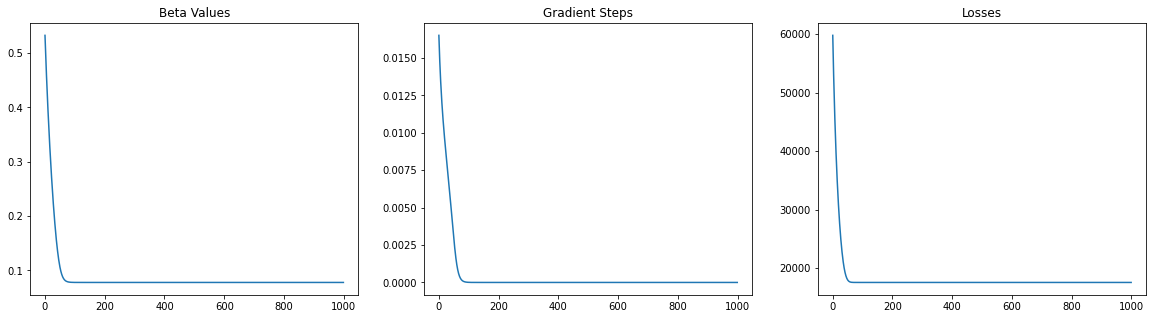

In [ ]:
# @title Find beta
np.random.seed(0)
beta = np.random.random()
x_t = dataset[:,0,:,:]
x_tt = dataset[:,1,:,:]

print(f"starting with beta={beta}")

derivative_fn = grad(neg_log_likelihood, argnums=2)

#print(x_t[0])
#print("----------------------")
#print(x_tt[0])
#print("----------------------\n Transition Probability Matrix:\n")
#print(P(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0),beta))
#print("----------------------\n negative log likelihood Matrix:\n")
#print(-jnp.log(P(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0),beta)))
#print("----------------------\n total negative log likelihood:\n")
#print(neg_log_likelihood(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0), beta))
#print("----------------------\n gradient of the negative log likelihood: \n")
#print(derivative_fn(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0), beta))

result, beta_hist, grad_steps, losses = train(x_t, x_tt, beta, derivative_fn, lr=1e-7)

fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.arange(len(beta_hist)), beta_hist, label="beta")
axs[0].set_title('Beta Values')
axs[1].plot(np.arange(len(beta_hist)), grad_steps, label="grad_steps")
axs[1].set_title('Gradient Steps')
axs[2].plot(np.arange(len(beta_hist)), losses, label="losses")
axs[2].set_title('Losses')

print(f"Final Beta: {result}")

Final Beta: 0.07797738164663315


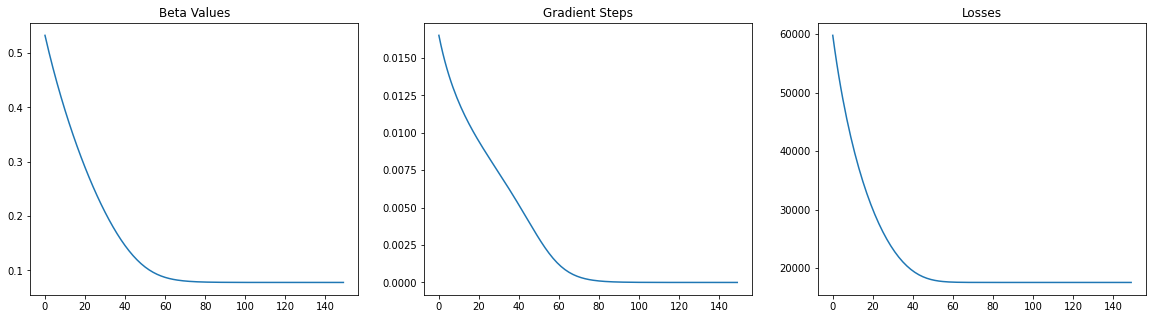

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.arange(150), beta_hist[:150], label="beta")
axs[0].set_title('Beta Values')
axs[1].plot(np.arange(150), grad_steps[:150], label="grad_steps")
axs[1].set_title('Gradient Steps')
axs[2].plot(np.arange(150), losses[:150], label="losses")
axs[2].set_title('Losses')

print(f"Final Beta: {result}")